In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

plt.style.use(r'customStyle')

# data processing
import loader as load

#import the working methods
import tensorflow as tf
print("TensorFlow version ",tf.__version__)

from tensorflow import keras


from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

TensorFlow version  2.18.0


In [2]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 100

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED_VALUE)

In [86]:
DATA_PATH = r"data/higgs-parsed.h5"

hdata = load.load_data_from_path(DATA_PATH)
data_fnames = hdata['feature_names'].to_numpy()[1:]
n_dims = data_fnames.shape[0]
print("Entries read {} with feature names {}".format(n_dims, data_fnames))

def split_xy_noscale(df):
    y = df['hlabel']                       # labels: 0=bkg, 1=sig
    X = df.drop(['hlabel'], axis=1)        # features
    return X, y

x_trn_raw, y_trn = split_xy_noscale(hdata['train'])
x_train_raw, x_test_raw, y_train, y_test = train_test_split(
    x_trn_raw, y_trn, test_size=0.1, stratify=y_trn, random_state=42
)
x_val_raw, y_val = split_xy_noscale(hdata['valid'])

scaler = MinMaxScaler().fit(x_train_raw)

def _tf(scaler, X):
    Xt = scaler.transform(X)
    return pd.DataFrame(Xt, columns=X.columns, index=X.index)

x_train = _tf(scaler, x_train_raw)
x_test  = _tf(scaler, x_test_raw)
x_val   = _tf(scaler, x_val_raw)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("x_val shape: ", x_val.shape)

Loading data/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
x_train shape:  (360000, 18)
x_test shape:  (40000, 18)
x_val shape:  (100000, 18)


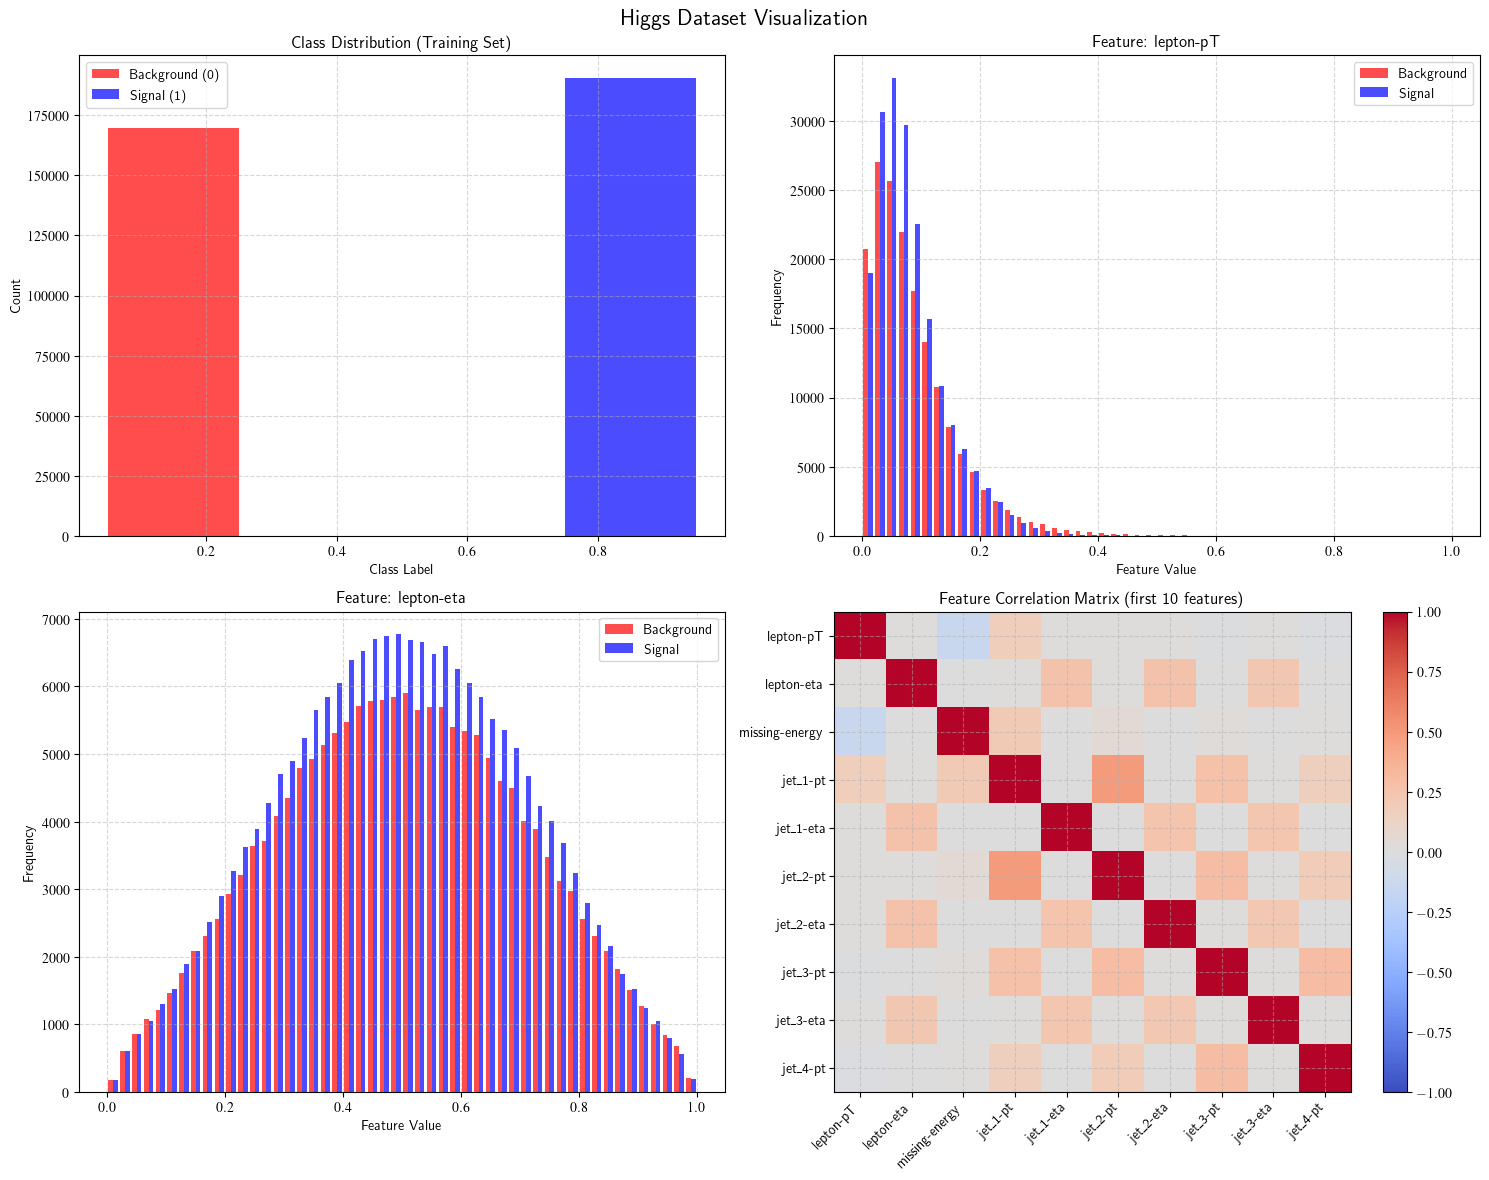

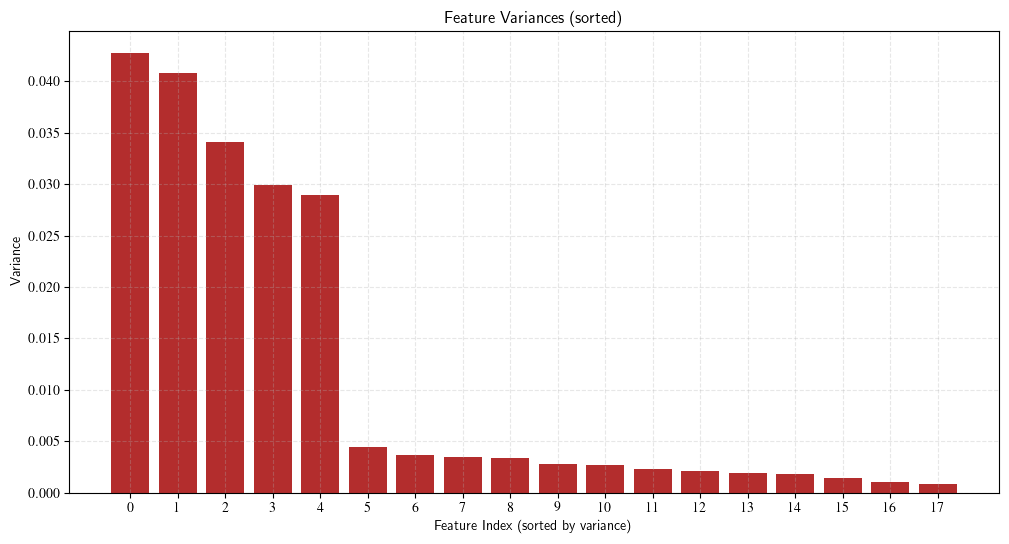


Dataset Statistics:
Training set: 360000 samples
Test set: 40000 samples
Validation set: 100000 samples
Number of features: 18
Signal ratio (training): 0.529
Signal ratio (validation): 0.529

First 10 feature names:
  0: lepton-pT
  1: lepton-eta
  2: missing-energy
  3: jet_1-pt
  4: jet_1-eta
  5: jet_2-pt
  6: jet_2-eta
  7: jet_3-pt
  8: jet_3-eta
  9: jet_4-pt


In [79]:
# Create multiple visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Higgs Dataset Visualization', fontsize=16)

# 1. Class distribution
axes[0, 0].hist([y_train[y_train == 0], y_train[y_train == 1]], 
                bins=2, alpha=0.7, label=['Background (0)', 'Signal (1)'],
                color=['red', 'blue'])
axes[0, 0].set_title('Class Distribution (Training Set)')
axes[0, 0].set_xlabel('Class Label')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()

# 2. Feature distributions for first few features (comparison between classes)
n_features_to_plot = min(4, n_dims)
for i in range(n_features_to_plot):
    if i < 2:
        row, col = 0, 1
        if i == 1:
            row, col = 1, 0
    else:
        row, col = 1, 1
        break  # Only plot 3 total in this layout
    
    # Plot distributions for background vs signal
    signal_data = x_train[y_train == 1].iloc[:, i]
    background_data = x_train[y_train == 0].iloc[:, i]
    
    if i < 2:
        axes[row, col].hist([background_data, signal_data], 
                           bins=50, alpha=0.7, 
                           label=['Background', 'Signal'],
                           color=['red', 'blue'])
        axes[row, col].set_title(f'Feature: {data_fnames[i]}')
        axes[row, col].set_xlabel('Feature Value')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].legend()

# 3. Correlation matrix (for subset of features)
n_corr_features = min(10, n_dims)
corr_matrix = x_train.iloc[:, :n_corr_features].corr()
im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1, 1].set_title(f'Feature Correlation Matrix (first {n_corr_features} features)')
axes[1, 1].set_xticks(range(n_corr_features))
axes[1, 1].set_yticks(range(n_corr_features))
axes[1, 1].set_xticklabels(data_fnames[:n_corr_features], rotation=45, ha='right')
axes[1, 1].set_yticklabels(data_fnames[:n_corr_features])
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Additional plot: Feature importance via variance
plt.figure(figsize=(12, 6))
feature_variances = x_train.var().sort_values(ascending=False)
plt.bar(range(len(feature_variances)), feature_variances.values)
plt.title('Feature Variances (sorted)')
plt.xlabel('Feature Index (sorted by variance)')
plt.ylabel('Variance')
plt.xticks(range(0, len(feature_variances), max(1, len(feature_variances)//10)))
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print(f"\nDataset Statistics:")
print(f"Training set: {x_train.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Number of features: {n_dims}")
print(f"Signal ratio (training): {y_train.mean():.3f}")
print(f"Signal ratio (validation): {y_val.mean():.3f}")

# Show first few feature names
print(f"\nFirst 10 feature names:")
for i, fname in enumerate(data_fnames[:10]):
    print(f"  {i}: {fname}")

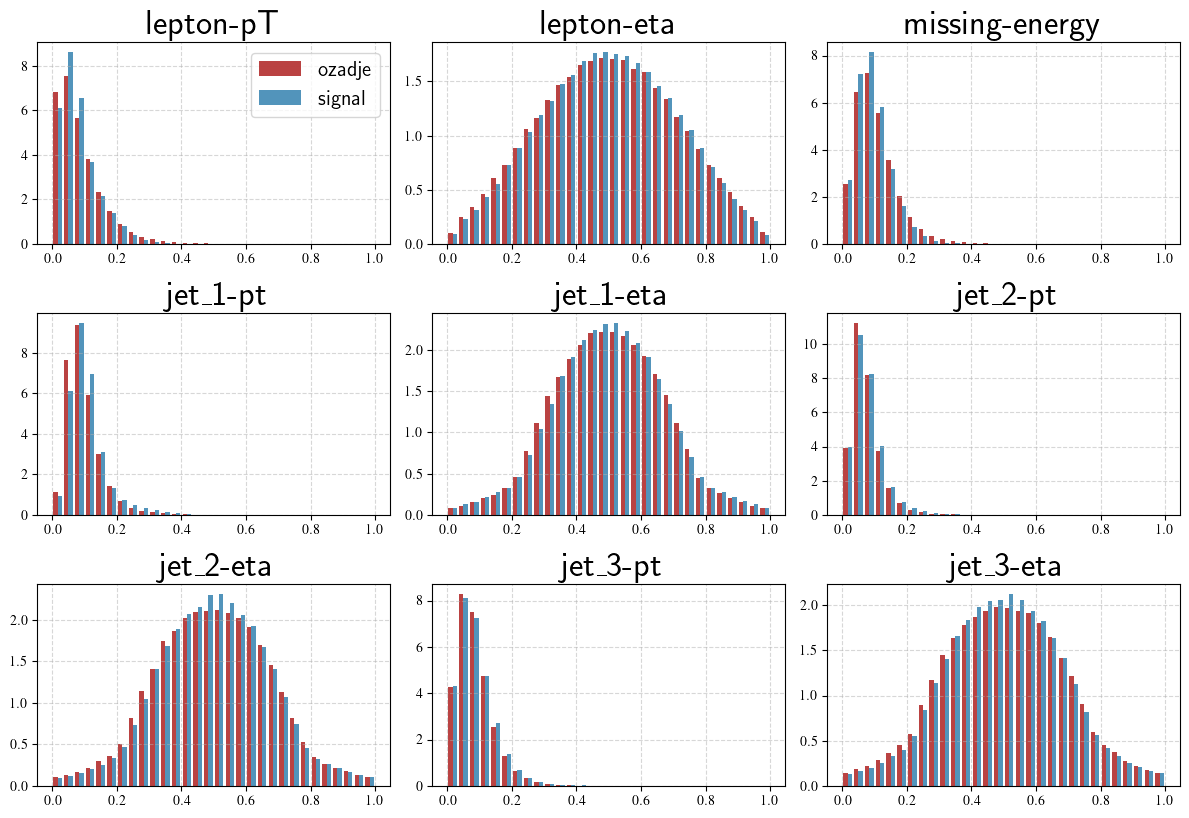

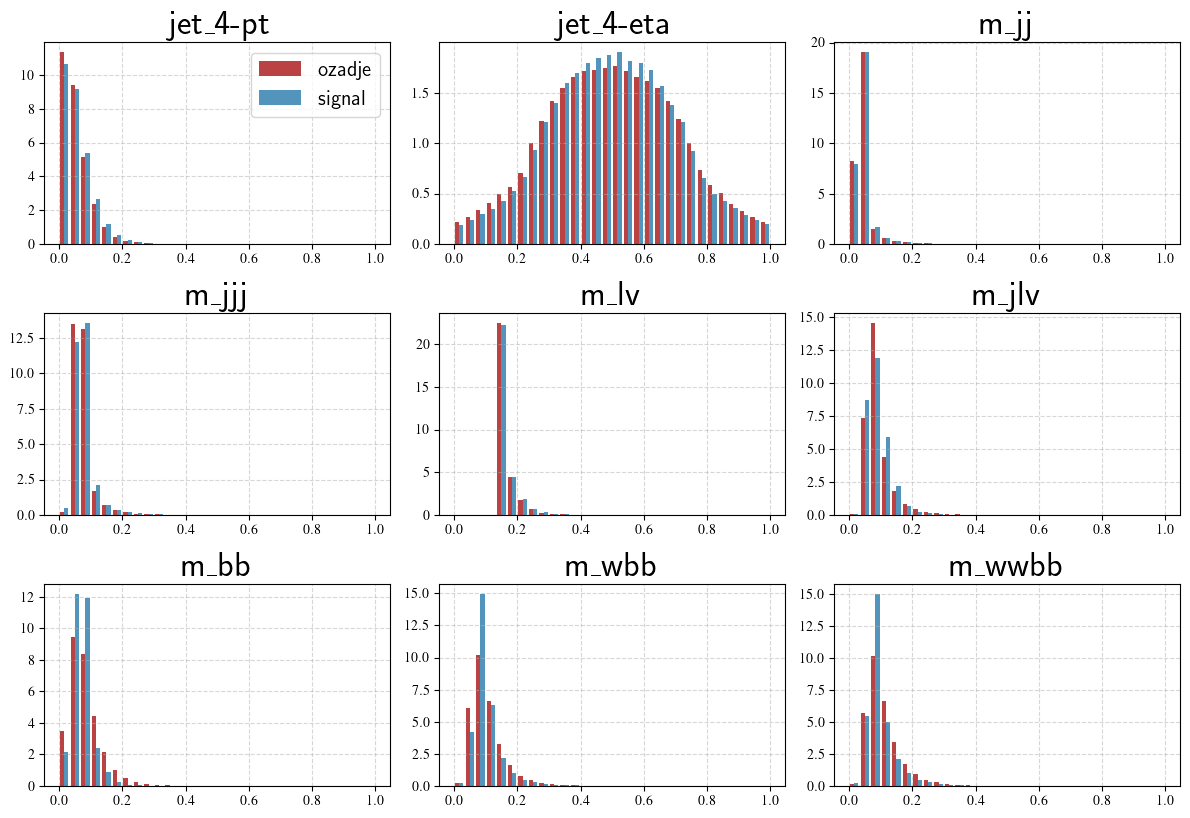

In [80]:
# Create two 3x3 subplots for all 18 features
# Optimized for LaTeX at 0.8\textwidth
fig1, axes1 = plt.subplots(3, 3, figsize=(12, 9))
fig2, axes2 = plt.subplots(3, 3, figsize=(12, 9))

# Flatten the axes arrays for easier indexing
axes1_flat = axes1.flatten()
axes2_flat = axes2.flatten()

# Plot first 9 features in the first figure
for i in range(9):
    # Get signal and background data for feature i
    signal_data = x_train[y_train == 1].iloc[:, i]
    background_data = x_train[y_train == 0].iloc[:, i]
    
    # Plot histograms with optimized settings for LaTeX
    axes1_flat[i].hist([background_data, signal_data],
                       bins=30, alpha=0.9,
                       label=['ozadje', 'signal'],
                       color=['#B32D2D', '#3F89B4'], density=True)
    axes1_flat[i].set_title(f'{data_fnames[i]}', fontsize=25)
    # axes1_flat[i].set_xlabel('Feature Value', fontsize=9)
    # axes1_flat[i].set_ylabel('Frequency', fontsize=9)
    # axes1_flat[i].tick_params(labelsize=8)
axes1_flat[0].legend(fontsize=15)

# Plot next 9 features in the second figure
for i in range(9, 18):
    # Get signal and background data for feature i
    signal_data = x_train[y_train == 1].iloc[:, i]
    background_data = x_train[y_train == 0].iloc[:, i]
    
    # Plot histograms with optimized settings for LaTeX
    axes2_flat[i-9].hist([background_data, signal_data],
                         bins=30, alpha=0.9,
                         label=['ozadje', 'signal'],
                         color=['#B32D2D', '#3F89B4'], density=True)
    axes2_flat[i-9].set_title(f'{data_fnames[i]}', fontsize=25)
    # axes2_flat[i-9].set_xlabel('Feature Value', fontsize=9)
    # axes2_flat[i-9].set_ylabel('Frequency', fontsize=9)
    # axes2_flat[i-9].tick_params(labelsize=8)
axes2_flat[0].legend(fontsize=15)

# Adjust layout for both figures with LaTeX optimization
# fig1.suptitle('Features 1-9: Signal vs Background Distribution', fontsize=12)
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])

# fig2.suptitle('Features 10-18: Signal vs Background Distribution', fontsize=12)
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save figures for LaTeX inclusion (optional)
# fig1.savefig('feat1.pdf', bbox_inches='tight', dpi=300)
# fig2.savefig('feat2.pdf', bbox_inches='tight', dpi=300)

# Show both plots
plt.show()

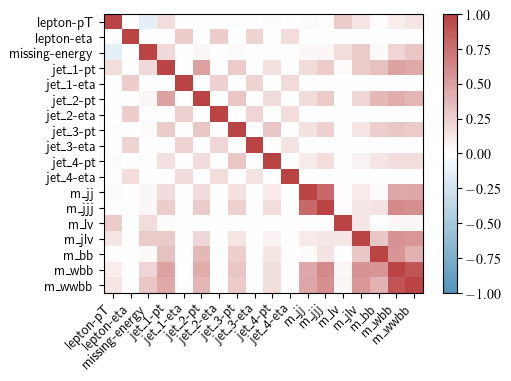

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# varneje: ne presezi dejanskega št. značilk
n_corr_features = min(max(10, n_dims), x_train.shape[1])

corr_matrix = x_train.iloc[:, :n_corr_features].corr()

# 3-točkovni divergenčni kolormap: levo -> sredina -> desno
cmap = LinearSegmentedColormap.from_list(
    'custom_div',
    ['#3F89B4', '#FFFFFF', '#B32D2D'],  # robovi po tvoji želji, center nevtralen
    N=256
)

# norma, centrirana pri 0 (korelacija), z robovi pri -1 in +1
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

im = plt.imshow(corr_matrix, cmap=cmap, norm=norm, aspect='auto', alpha=0.9)

plt.xticks(range(n_corr_features), data_fnames[:n_corr_features], rotation=45, ha='right')
plt.yticks(range(n_corr_features), data_fnames[:n_corr_features])

plt.grid(False)
plt.colorbar(im)
plt.tight_layout()
# plt.savefig('corr.pdf', bbox_inches='tight', dpi=300)
plt.show()


Št. razredov: 2
Št. LDA komponent: 1
Delež pojasnjene variance (LDA): [1.]
Kumulativno: [1.]


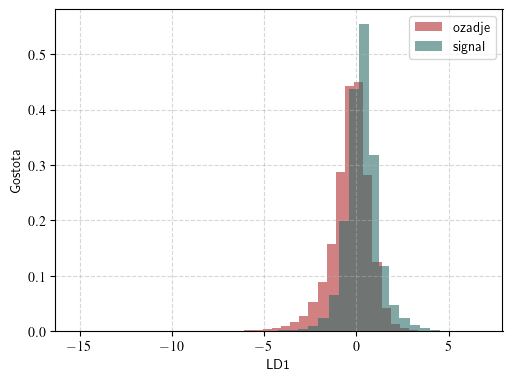


Top 10 prispevkov za LD1:
m_wwbb            25.849891
m_bb              19.143652
m_wbb             18.259553
m_jjj              9.654327
jet_1-pt           9.236219
m_jlv              6.268226
missing-energy     6.080064
m_jj               5.827647
m_lv               5.469513
lepton-pT          4.198958
jet_4-pt           2.805877
jet_2-pt           2.000638
jet_3-pt           1.115529
jet_1-eta          0.077135
jet_2-eta          0.076172
lepton-eta         0.034696
jet_4-eta          0.019985
jet_3-eta          0.012867
Name: LD1, dtype: float64


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- Po tvojem obstoječem split_xy / pripravi podatkov ---

# Nastavi število komponent: pri LDA je max = št.razredov - 1
n_classes = np.unique(y_train).size
n_features = x_train.shape[1]
n_lda = min(n_features, n_classes - 1)
if n_lda <= 0:
    raise ValueError("LDA potrebuje vsaj 2 razreda.")

lda = LDA(n_components=n_lda, solver='svd')  # privzeti 'svd' daje explained_variance_ratio_

# Učenje na treningu
x_train_lda = lda.fit_transform(x_train, y_train)
# Enak projektor uporabimo za validacijo in test
x_val_lda   = lda.transform(x_val)
x_test_lda  = lda.transform(x_test)

print("Št. razredov:", n_classes)
print("Št. LDA komponent:", n_lda)

# Razmerje pojasnjene variance (koliko separacije prispeva posamezna LDA komponenta)
# Opomba: na voljo za solver='svd'
if hasattr(lda, "explained_variance_ratio_") and lda.explained_variance_ratio_ is not None:
    evr = lda.explained_variance_ratio_
    print("Delež pojasnjene variance (LDA):", evr)
    print("Kumulativno:", np.cumsum(evr))
else:
    print("explained_variance_ratio_ ni na voljo za izbrani solver.")

# --- Vizualizacija ---
# 1D projekcija za binarni primer
plt.figure()
plt.hist(x_train_lda[y_train==np.unique(y_train)[0]], bins=40, alpha=0.6, label="ozadje", density=True)
plt.hist(x_train_lda[y_train==np.unique(y_train)[1]], bins=40, alpha=0.6, label="signal", density=True)
plt.xlabel('LD1')
plt.ylabel('Gostota')
# plt.title('LDA projekcija (1D)')
plt.legend()
plt.tight_layout()
# plt.savefig('lda.pdf', bbox_inches='tight', dpi=300)
plt.show()

# --- "Loadings" / prispevki značilk k LDA komponentam ---
# Pri LDA projicira 'scalings_' (osnovne smeri). Uporabimo jih podobno kot pri PCA komponentah.
# Dimenzije: (n_features, n_lda)
if hasattr(lda, "scalings_") and lda.scalings_ is not None:
    loadings_lda = pd.DataFrame(
        lda.scalings_[:, :n_lda],
        columns=[f'LD{i+1}' for i in range(n_lda)],
        index=x_train.columns
    )
    # Top značilke za LD1 po absolutni vrednosti
    top_LD1 = loadings_lda['LD1'].abs().sort_values(ascending=False)
    print("\nTop 10 prispevkov za LD1:")
    print(top_LD1)
else:
    print("scalings_ ni na voljo; ni mogoče izpisati prispevkov značilk.")


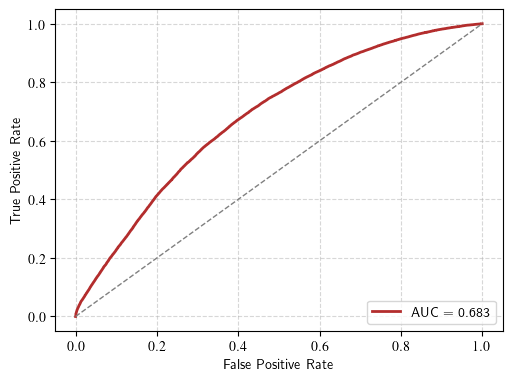

Train AUC: 0.6814
Valid AUC: 0.6830
Test AUC: 0.6811


In [84]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def _scores(est, X):
    # Prefer decision_function (often better calibrated for ranking)
    if hasattr(est, "decision_function"):
        s = est.decision_function(X)
        if s.ndim > 1:  # in case some estimators return 2 cols
            s = s[:, 1]
        return s
    elif hasattr(est, "predict_proba"):
        p = est.predict_proba(X)
        return p[:, 1] if p.ndim == 2 and p.shape[1] > 1 else p.ravel()
    else:
        raise ValueError("Estimator has neither decision_function nor predict_proba.")

# --- Compute ROC + AUC for each split ---
splits = {
    "Train": (x_train, y_train),
    "Valid": (x_val,   y_val),
    "Test":  (x_test,  y_test),
}

roc_data = {}
for name, (X, y) in splits.items():
    y_score = _scores(lda, X)
    fpr, tpr, _ = roc_curve(y, y_score)  # assumes labels are {0,1}; set pos_label if needed
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

# --- Plot (single figure, multiple curves) ---
for name, (fpr, tpr, roc_auc) in roc_data.items():
    if name == 'Valid':
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")

plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, c='grey')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC curves")
plt.legend(loc="lower right")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
plt.tight_layout()
plt.savefig('roc_lda.pdf', bbox_inches='tight', dpi=300)
plt.show()

# If you also want the raw AUC numbers:
for name, (_, _, roc_auc) in roc_data.items():
    print(f"{name} AUC: {roc_auc:.4f}")
